This file mainly involves data visualization and preprocessing.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder

In [ ]:
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/comp4211/project

/content/drive/MyDrive/comp4211/project


In [ ]:
mbti_labels_multi = pd.read_csv('mbti_labels_multi.csv')

In [ ]:
mbti_labels_multi

,id,mbti_personality,E/I,N/S,F/T,J/P
0,28968838,infp,1,0,0,1
1,2325006565,infp,1,0,0,1
2,907848145,infp,1,0,0,1
3,1330237585,infp,1,0,0,1
4,97687049,infp,1,0,0,1
...,...,...,...,...,...,...
6006,52277872,estj,0,1,1,0
6007,3061139834,estj,0,1,1,0
6008,329077476,estj,0,1,1,0
6009,781835161394614272,estj,0,1,1,0


In [ ]:
user_info = pd.read_csv('mbti-dataset/user_info.csv')

In [ ]:
user_info

,id,id_str,name,screen_name,location,description,verified,followers_count,friends_count,listed_count,...,total_mentions_count,total_media_count,number_of_tweets_scraped,average_tweet_length,average_retweet_count,average_favorite_count,average_hashtag_count,average_url_count,average_mentions_count,average_media_count
0,28968838,28968838,pao,paoacflores,Mandaluyong/StaCruz Laguna PH,right brained lefty. infp. hufflepuff. collect...,False,14135,1338,47,...,156,34,200.0,16.150000,3718.745000,1.695000,0.410000,0.215000,0.780000,0.170000
1,2325006565,2325006565,pengu🌻❤️🍓@青鳥王国,PenguPooh,PengUstine CCTV,🇹🇼🇯🇵🇺🇸｜♋E/INFP｜和↔英｜20⬆｜chaotic bi｜高浮上｜181001｜佐...,False,1223,604,31,...,170,40,199.0,9.668342,3722.211055,0.824121,0.356784,0.195980,0.854271,0.201005
2,907848145,907848145,lynn bean,sukaihan,Singapore,"eng, 中 | exo, x-exo and wayv 💕 | 22 | scorpio ...",False,8512,312,147,...,174,77,192.0,14.718750,10028.718750,1.526042,0.401042,0.130208,0.906250,0.401042
3,1330237585,1330237585,Sei💫,nemuiryuu,NaN,【INFP】He/Him ✧ CEO of gothic idols ★ 蘭子P,False,1805,340,69,...,127,99,200.0,7.655000,827.370000,2.190000,0.080000,0.055000,0.635000,0.495000
4,97687049,97687049,Freda`,TheFredaLee,London,Arts Psychotherapist/RDMP - CAMHS| Personal De...,False,2872,2172,167,...,189,33,197.0,16.380711,6716.137056,0.071066,0.055838,0.076142,0.959391,0.167513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006,52277872,52277872,Cyndi Walsh,loowho11,"San Antonio, Texas",Hill Country Lover. ESTJ. Momma. Wife. Live M...,False,616,836,33,...,33,0,200.0,15.440000,0.335000,0.385000,0.430000,1.115000,0.165000,0.000000
6007,3061139834,3061139834,AF,estjHoran,NaN,Fangirling since 96',False,43,128,0,...,259,2,199.0,17.844221,6.628141,0.025126,1.291457,0.000000,1.301508,0.010050
6008,329077476,329077476,Michael K Williams,Williams_ESTJ,NaN,Football coach,False,103,115,0,...,98,8,109.0,13.504587,40.119266,0.110092,0.422018,0.110092,0.899083,0.073394
6009,781835161394614272,781835161394614272,EstudiantinaStj2016,EStj2016,"Neuquén, Argentina",Ya llega la mejor estudiantina del Santa Teres...,False,49,119,0,...,12,26,74.0,14.675676,3.202703,1.500000,0.391892,0.108108,0.162162,0.351351


In [ ]:
numerical_features = ['followers_count',
 'friends_count',
 'listed_count',
 'favourites_count',
 'statuses_count',
 'number_of_quoted_statuses',
 'number_of_retweeted_statuses',
 'average_tweet_length',
 'average_retweet_count',
 'average_favorite_count',
 'average_hashtag_count',
 'average_url_count',
 'average_mentions_count',
 'average_media_count']
categorical_features = ['verified']

In [ ]:
df = user_info[['id', 'screen_name', 'description'] + numerical_features + categorical_features]

In [ ]:
# One-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
onehot_encoded = onehot_encoder.fit_transform(df[categorical_features])

onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_features))
df_merged = pd.concat([df, onehot_encoded_df], axis=1)
df_merged.drop(categorical_features, axis=1, inplace=True)

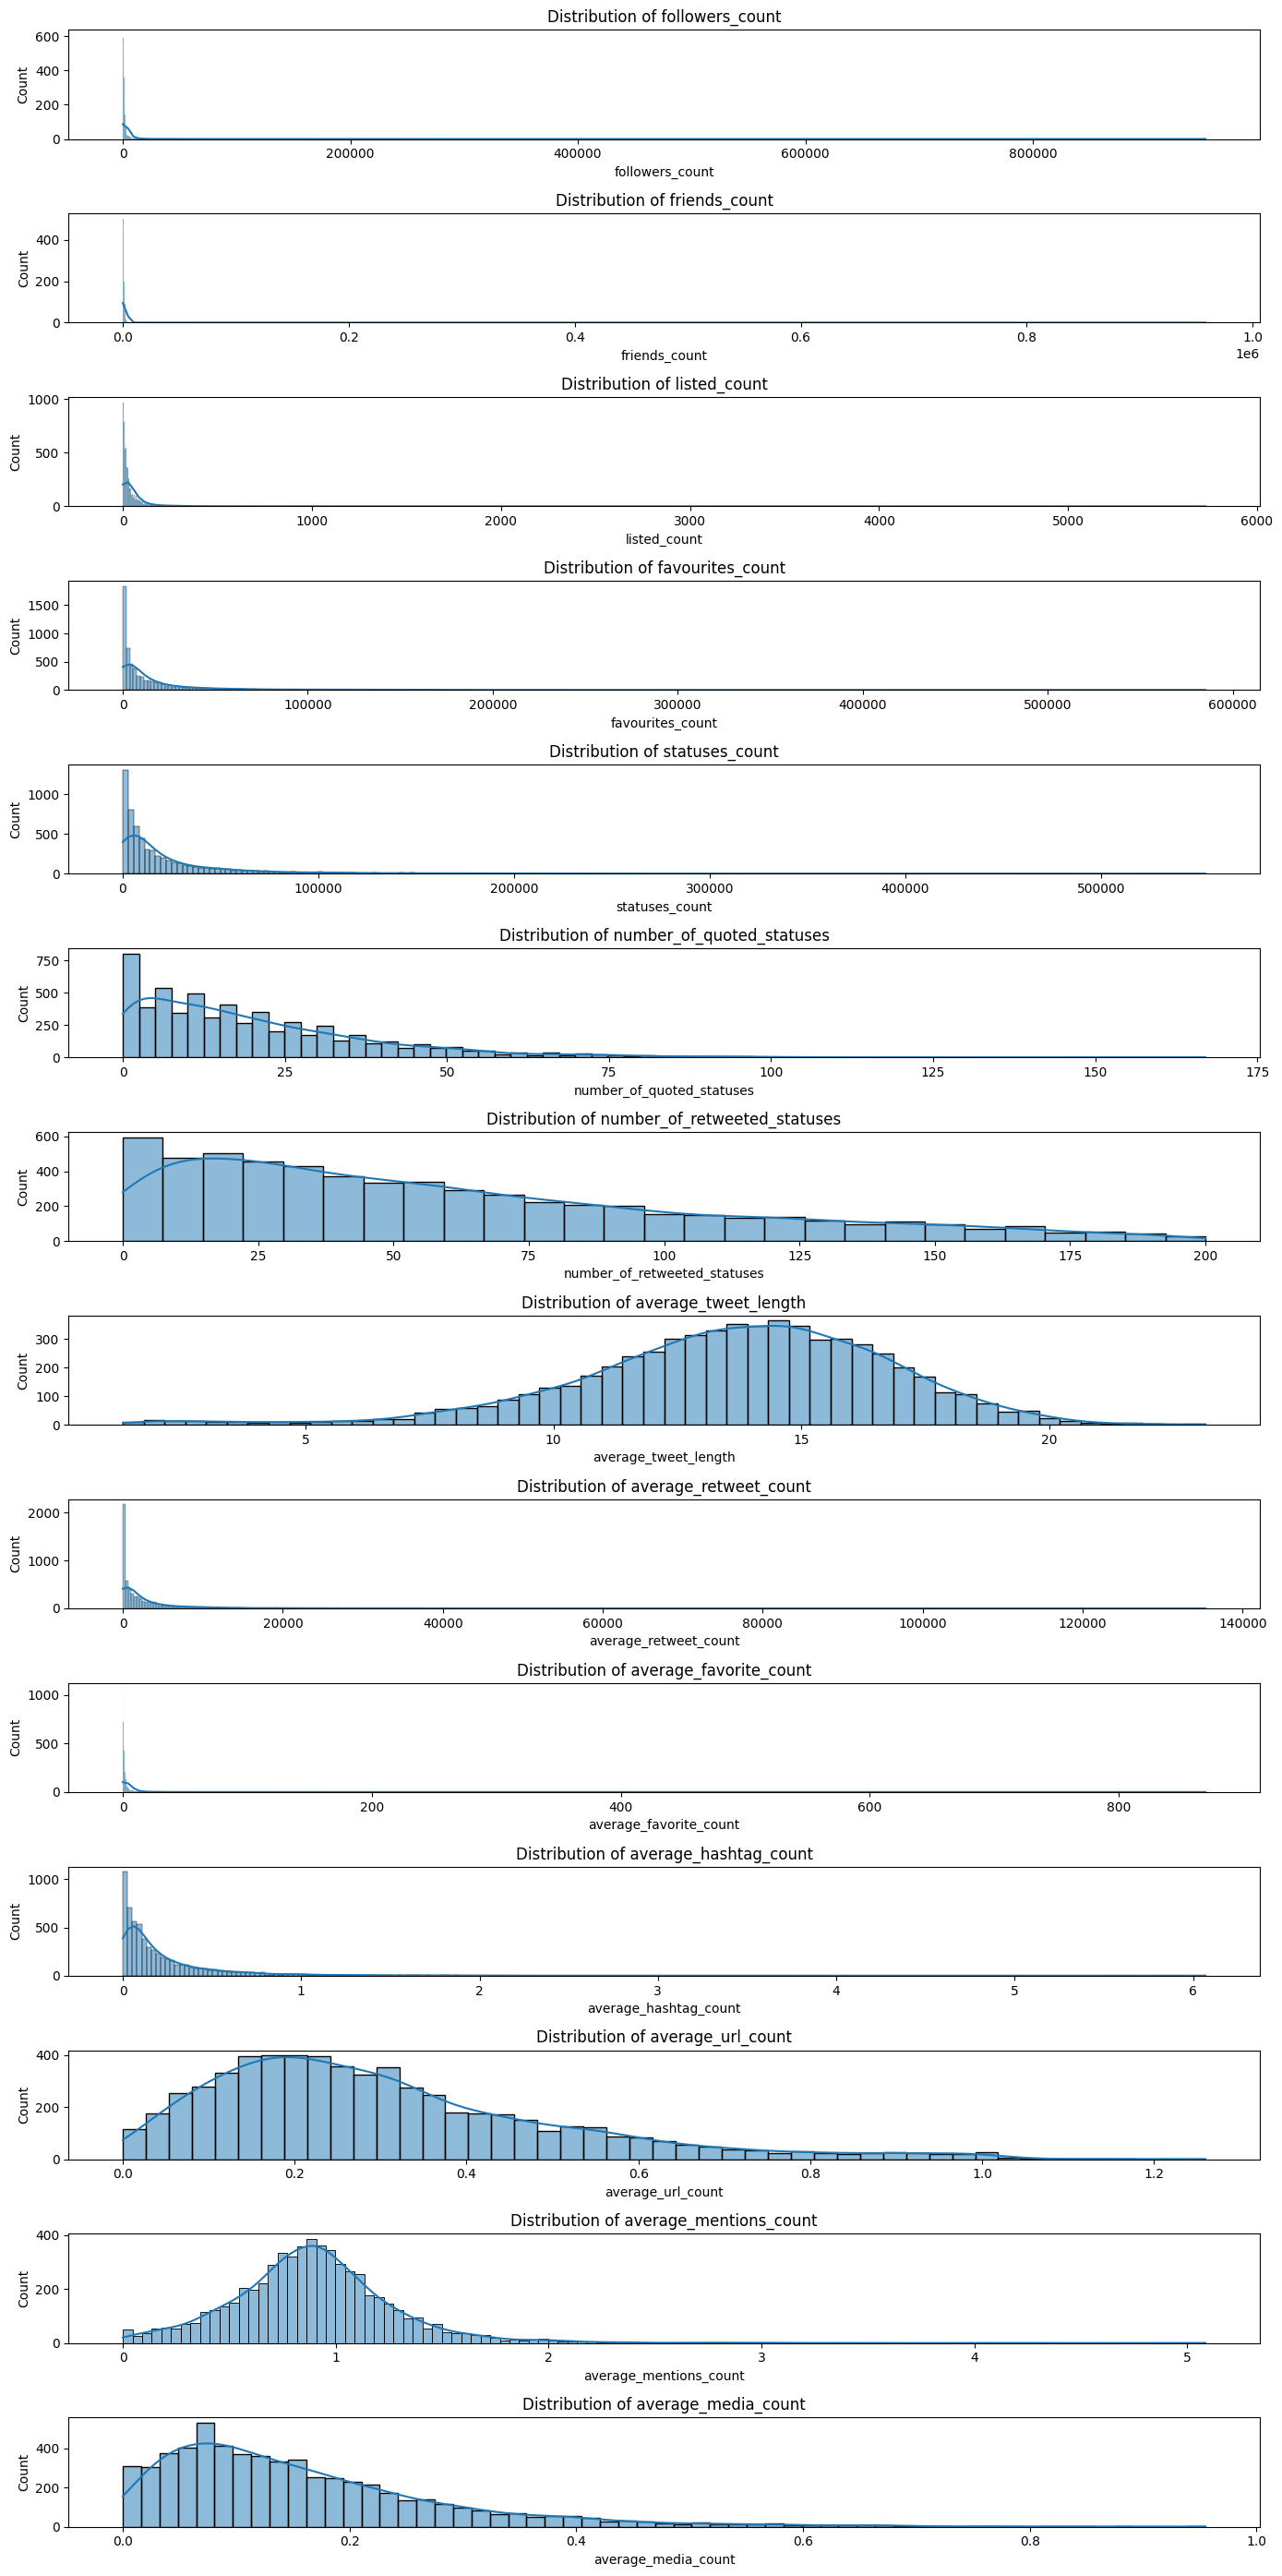

In [ ]:
numerical_columns = df[numerical_features].columns

plt.figure(figsize=(14, 28))

# Loop over the numerical columns to create subplots
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Log transformation. Add theta to avoid zeros, where theta is defined as the smallest non-zero value under a feature divided by a given factor.
def log_processing(df, features, factor):
    df = df.copy()
    thetas = {}
    for i in features:
        theta = np.min(df[i].to_numpy()[np.nonzero(df[i])])/factor
        df[i] = np.log(df[i]+theta)
        thetas[i] = theta
    return df, thetas

In [ ]:
feaures_for_log_processing = ['followers_count',
 'friends_count',
 'listed_count',
 'favourites_count',
 'statuses_count',
 'number_of_quoted_statuses',
 'number_of_retweeted_statuses',
 'average_retweet_count',
 'average_favorite_count',
 'average_hashtag_count',
 'average_url_count',
 'average_mentions_count',
 'average_media_count']

In [ ]:
df_log, log_thetas = log_processing(df_merged, feaures_for_log_processing, np.e)

In [ ]:
# Save log_thetas to the file
file_path_log_thetas = f'/content/drive/MyDrive/comp4211/project/log_thetas.pkl'
with open(file_path_log_thetas, 'wb') as file:
    pickle.dump(log_thetas, file)

In [ ]:
# Load log_thetas
with open(file_path_log_thetas, 'rb') as file:
    log_thetas = pickle.load(file)

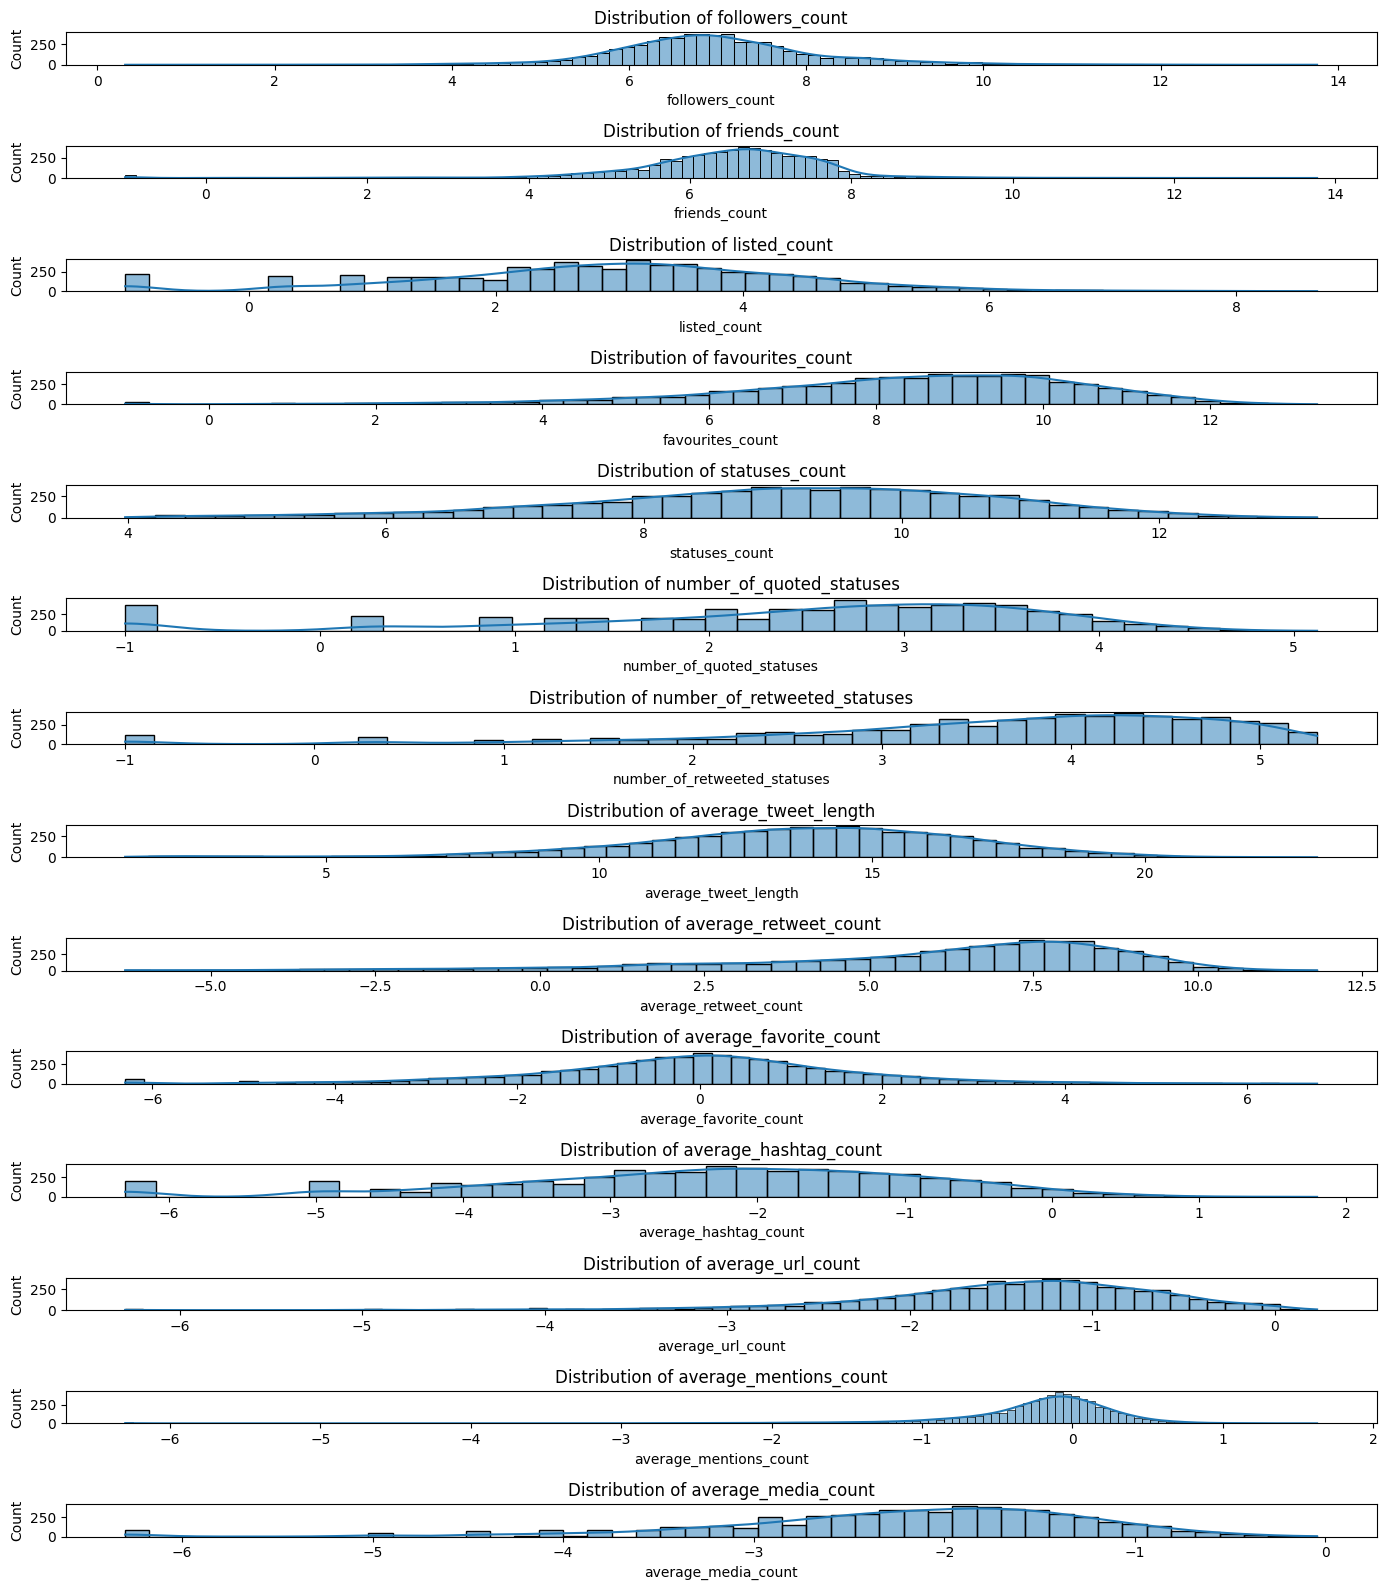

In [ ]:
numerical_columns = df_log[numerical_features].columns

plt.figure(figsize=(14, 16))

# Loop over the numerical columns to create subplots
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.histplot(df_log[col], kde=True)
    plt.title(f'Distribution of {col}')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Train-test splitting
X = df_log.copy()
y = mbti_labels_multi[['E/I', 'N/S', 'F/T', 'J/P']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

In [ ]:
X_val[numerical_features] = scaler.transform(X_val[numerical_features])

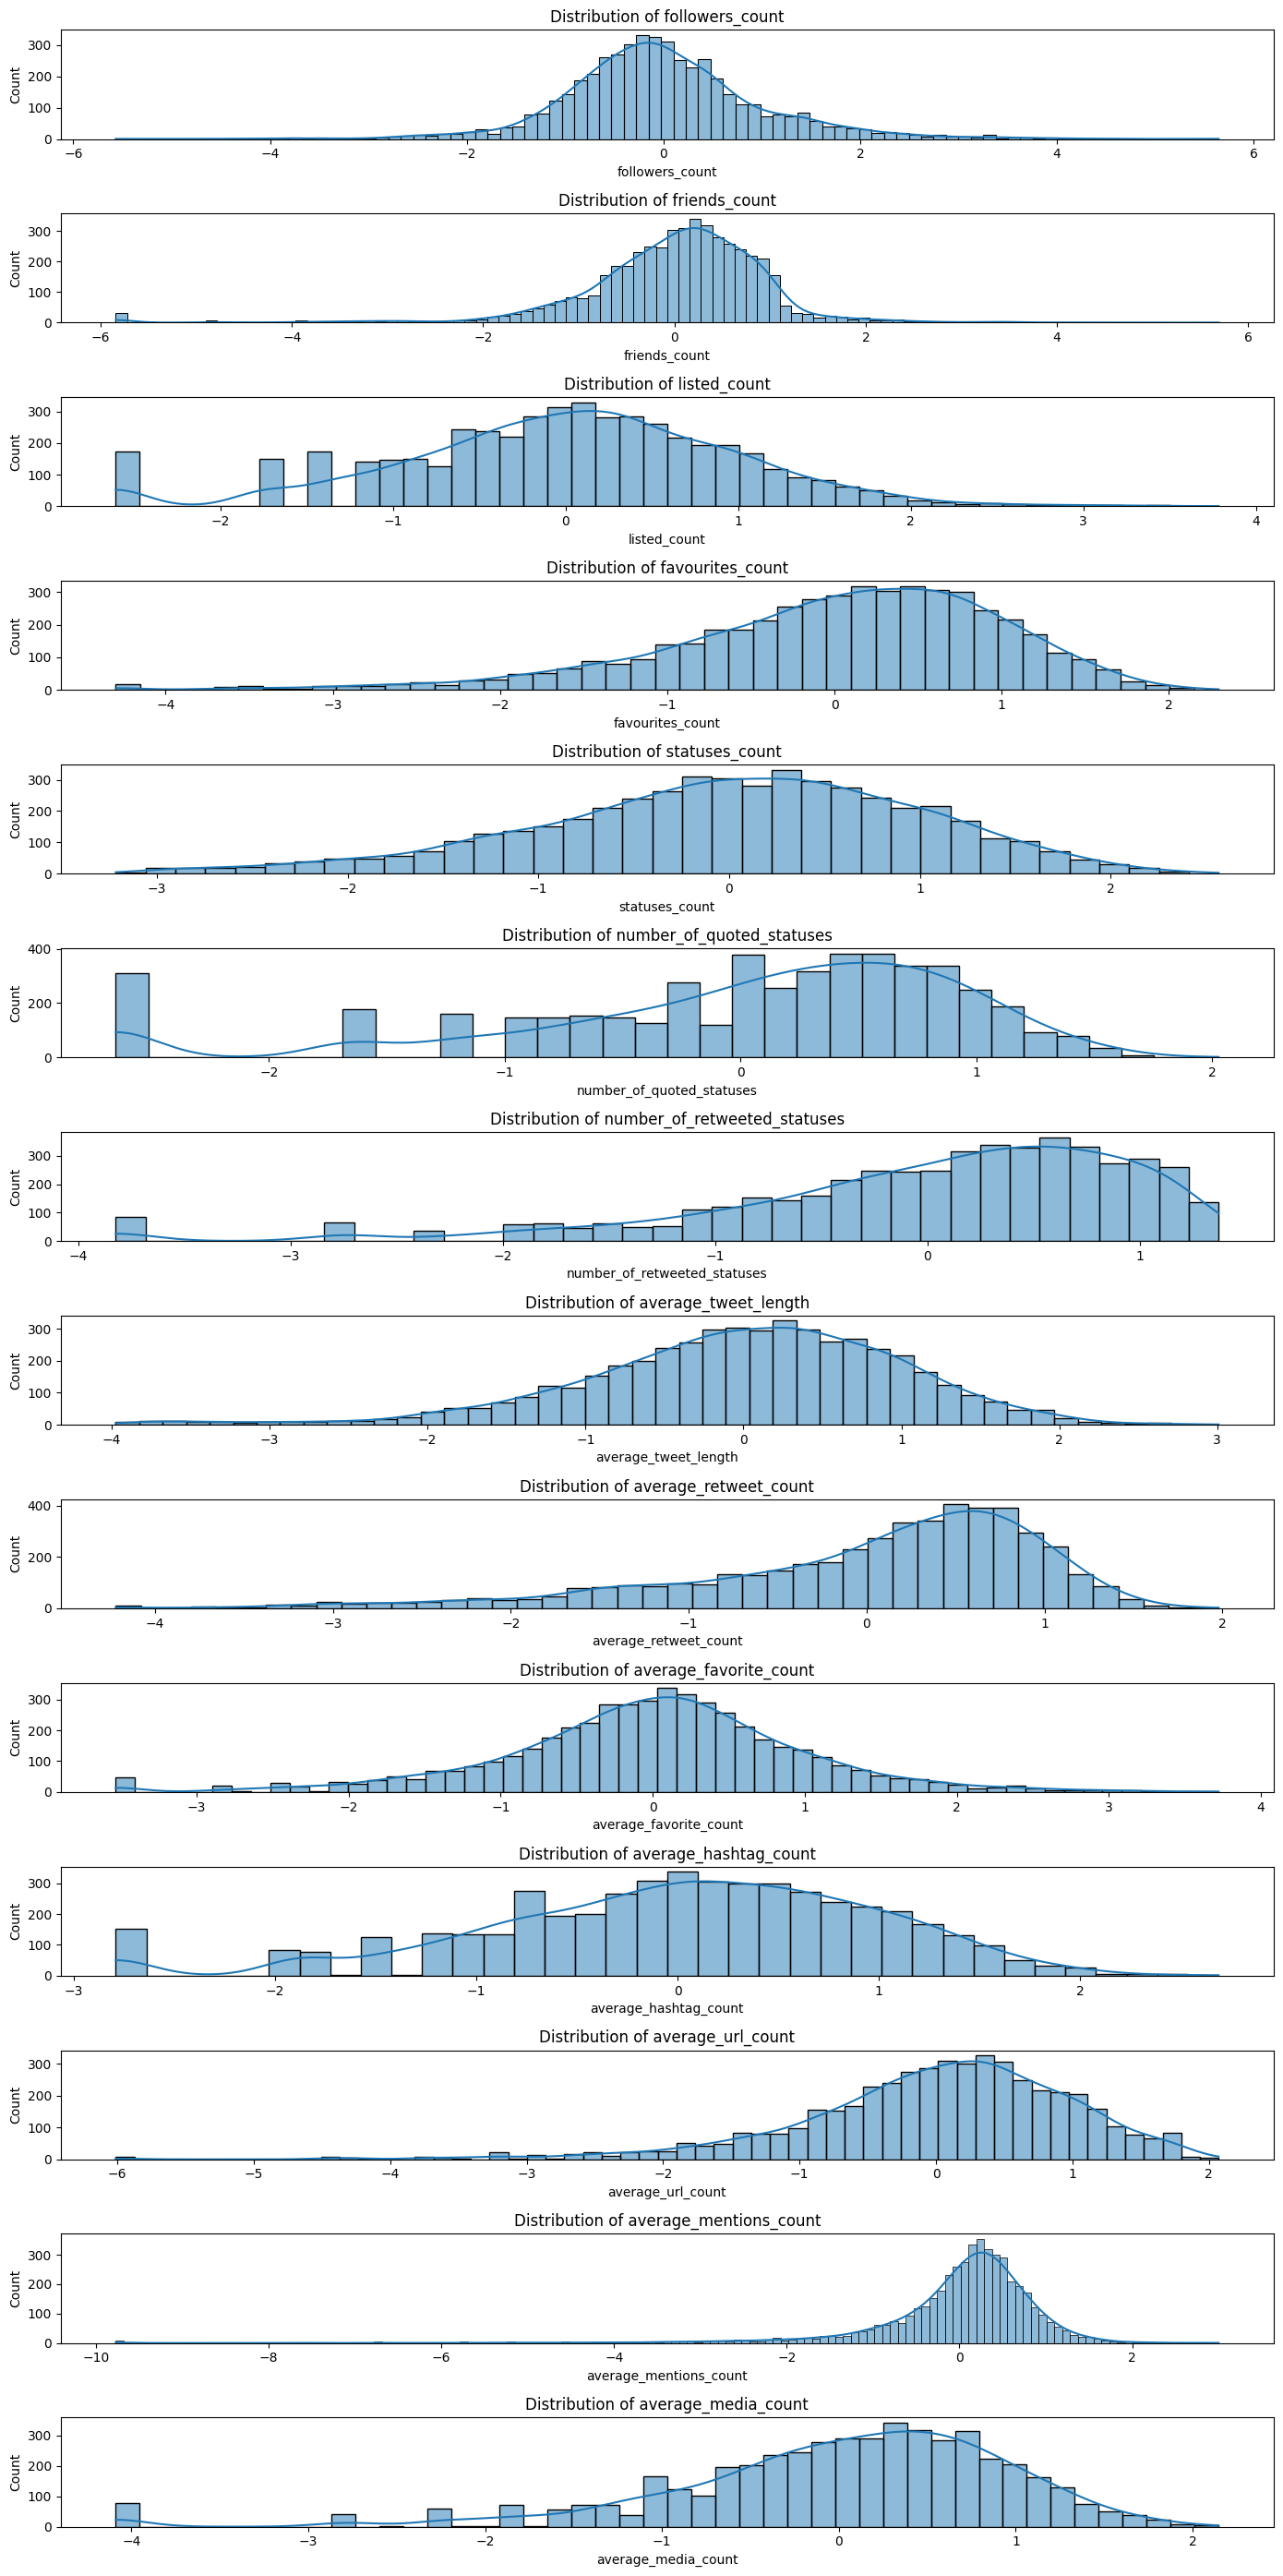

In [ ]:
numerical_columns = X_train[numerical_features].columns

plt.figure(figsize=(14, 28))

# Loop over the numerical columns to create subplots
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.histplot(X_train[col], kde=True)
    plt.title(f'Distribution of {col}')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

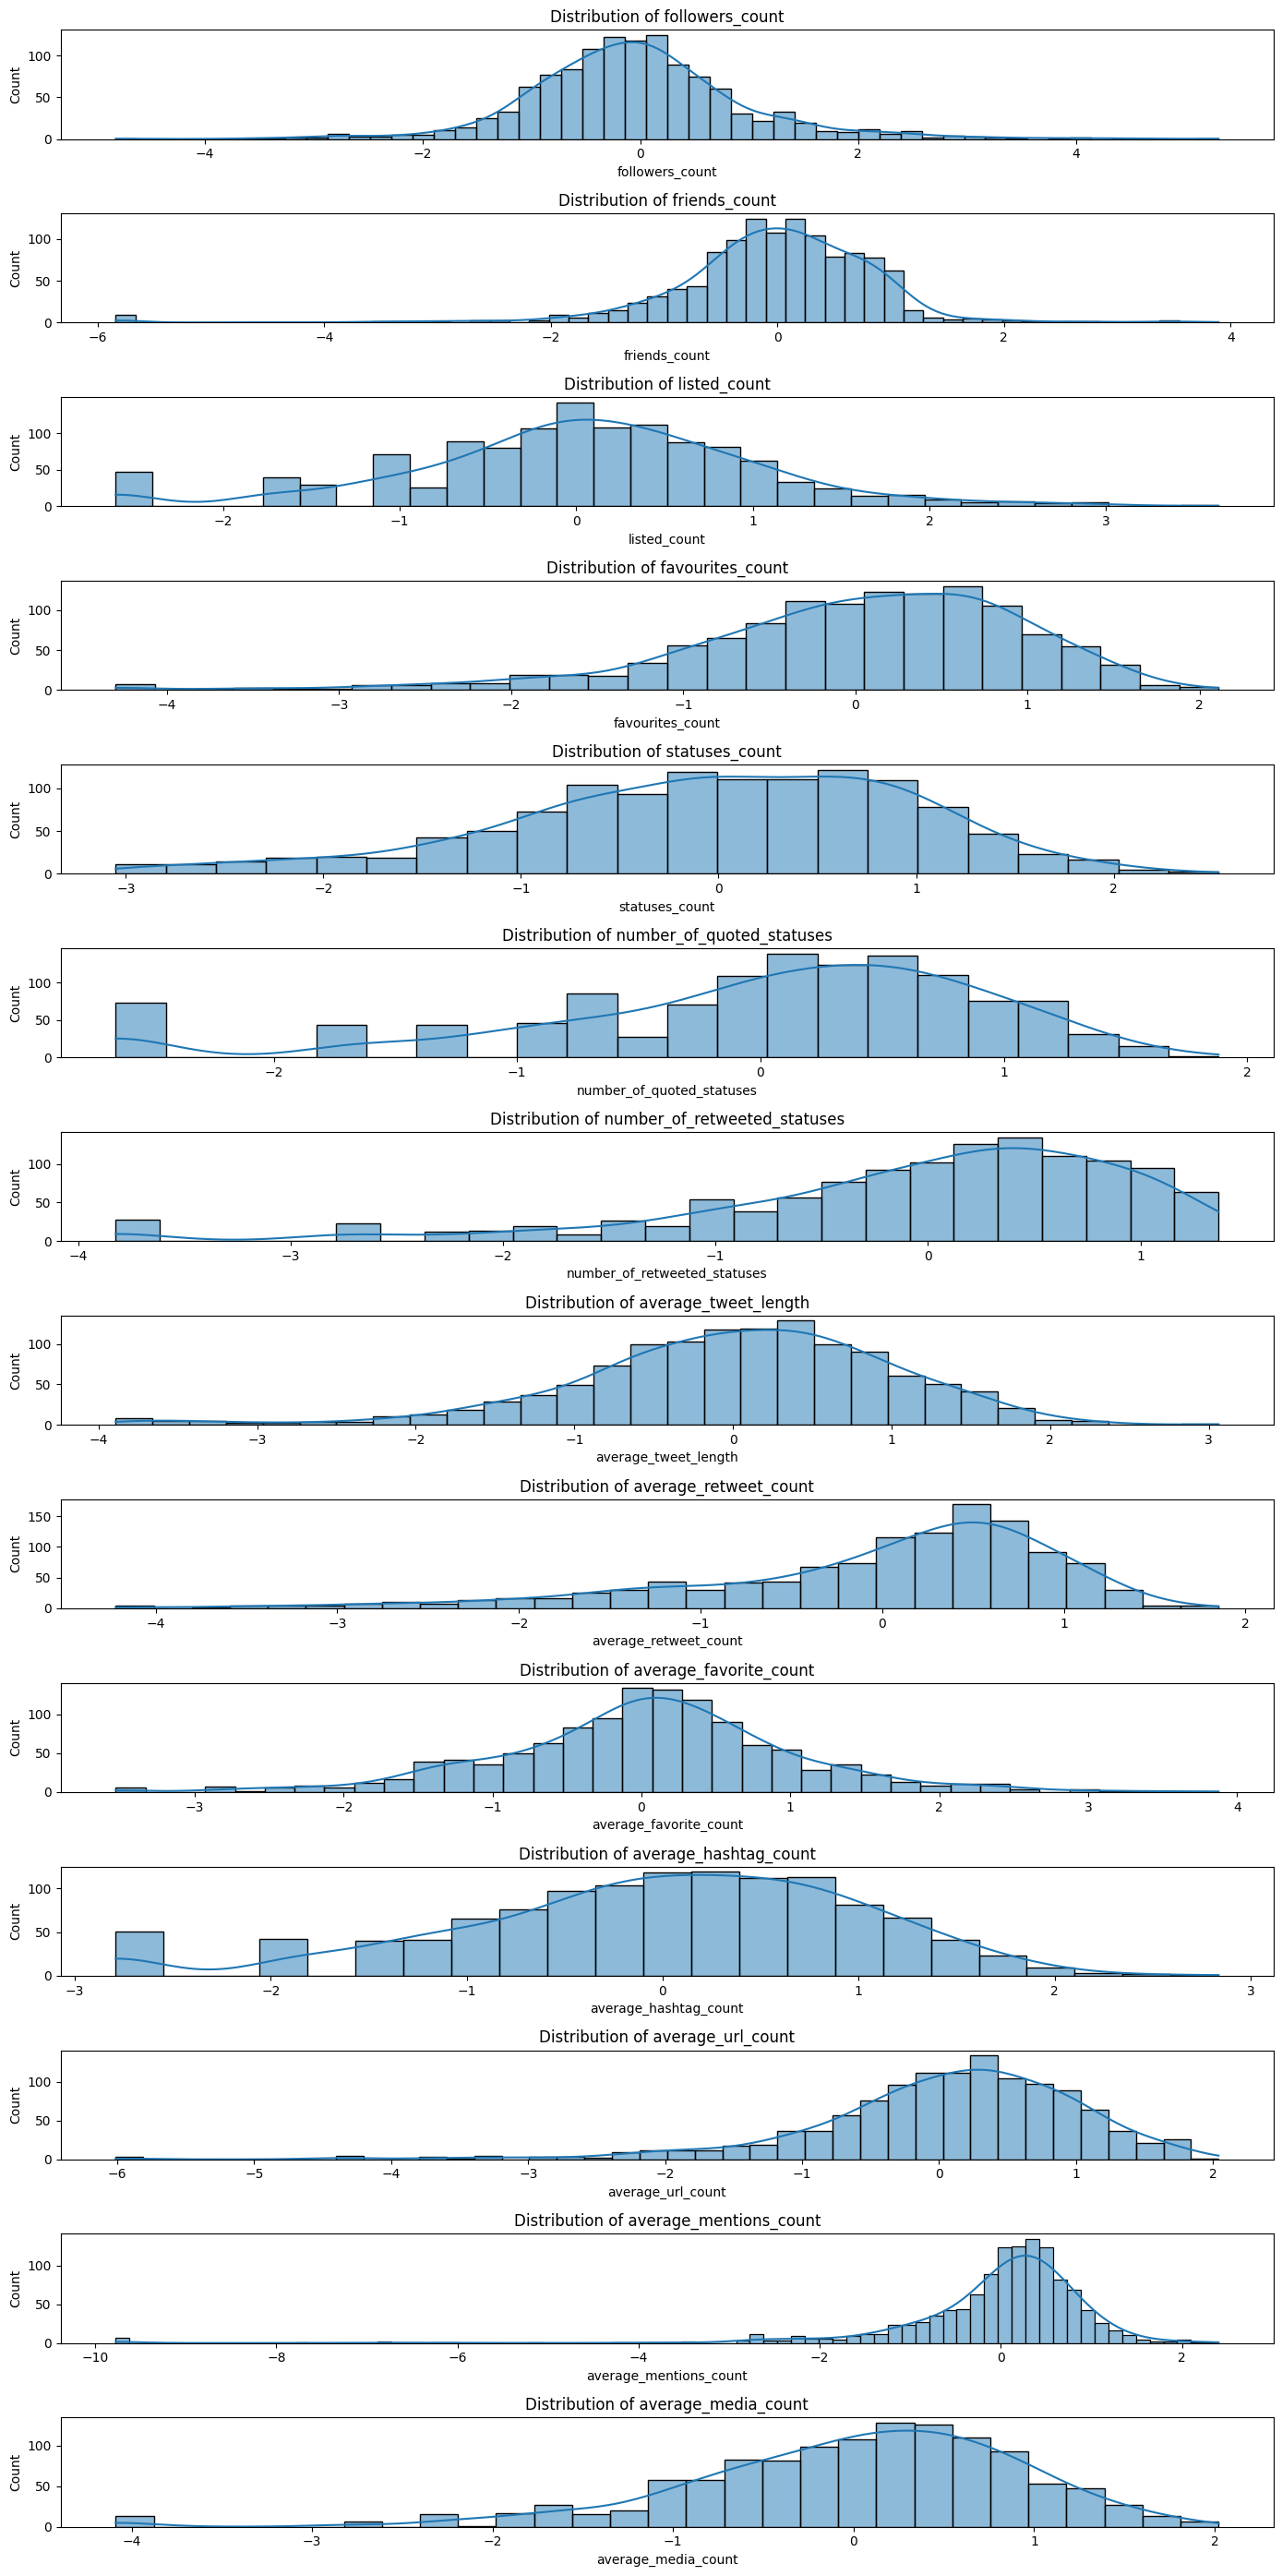

In [ ]:
numerical_columns = X_val[numerical_features].columns

plt.figure(figsize=(14, 28))

# Loop over the numerical columns to create subplots
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.histplot(X_val[col], kde=True)
    plt.title(f'Distribution of {col}')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
user_info_preprocessed = pd.concat([X_train, X_val],axis=0)

In [ ]:
X_train

,id,screen_name,description,followers_count,friends_count,listed_count,favourites_count,statuses_count,number_of_quoted_statuses,number_of_retweeted_statuses,average_tweet_length,average_retweet_count,average_favorite_count,average_hashtag_count,average_url_count,average_mentions_count,average_media_count,verified_True
4434,229483255,Kit_katei,Asun 🏳‍🌈 I draw cute OCs and personal stuff.[E...,0.515161,-0.395199,0.356763,1.340438,1.694481,0.748352,0.461088,-1.502548,0.121357,1.783862,-0.929321,-0.166714,-0.285309,1.551986,0.0
2350,1697504899,thenatejc,ENTP - Semifinalist Austin Film Fest screenpla...,-0.812894,0.242253,-0.336126,0.055313,-0.377556,0.096505,0.473422,0.453304,0.748069,0.054638,0.848487,0.259372,0.476711,0.518524,0.0
5335,57358661,NicoleForbis,Cutting Edge Tech & Marketing\n💯Serial Entrepr...,1.553804,1.811698,2.436492,0.091631,0.049695,-0.097721,1.223954,1.157735,-0.484142,-1.252432,1.679758,1.140639,0.670950,0.248749,0.0
3303,133886184,ajax_63,"Technology, healthcare, change, learning & lea...",0.001024,0.567939,0.851899,-1.025547,-0.618083,1.261237,0.051046,0.815797,-0.847564,-0.416990,0.454941,1.548305,0.073489,-0.759637,0.0
5977,414075108,MatthewCoco,"Digital Director @lpigroup, Founder @podcastea...",-0.133653,0.000097,1.386899,-0.450893,-0.884399,-0.758361,-1.472052,0.743298,-2.612414,-0.484255,1.376670,1.682916,-1.326881,0.835748,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,2373620092,ohitsjodee,"chaotic good, virgo, enfj",-0.724553,0.178484,-0.969511,0.742042,-0.416151,-0.097721,1.151910,1.161416,1.279349,-0.258194,-2.791498,-1.599453,0.194521,-0.317337,0.0
5191,728524850197729280,artlubiano,Now a corporate man. Formerly with @rapplerdot...,-0.203778,-0.255971,-0.623289,0.775865,0.722020,0.523341,0.090927,-0.329274,0.628530,0.008329,-0.614207,0.250343,-0.293695,0.554776,0.0
5226,2334566635,PanScoli,"He/Him; ENTJ; Artist, pec enthusiast, yet all ...",0.838073,0.257843,-0.464262,1.323694,0.664799,0.251239,0.865472,-0.139574,0.472503,0.235122,-0.542458,-1.240878,0.767604,1.060657,0.0
5390,159978793,destinywrites,"#digitalmarketer, #writer, #bosslady & #Dallas...",0.105572,0.039639,0.842142,-0.032317,-0.203159,0.795589,0.051046,0.531113,0.248103,0.610038,0.996143,0.750536,0.061936,0.549801,0.0


In [ ]:
X_val

,id,screen_name,description,followers_count,friends_count,listed_count,favourites_count,statuses_count,number_of_quoted_statuses,number_of_retweeted_statuses,average_tweet_length,average_retweet_count,average_favorite_count,average_hashtag_count,average_url_count,average_mentions_count,average_media_count,verified_True
79,57194960,sepuuut,26 | INFP | IG : sepuuut\nsupercalifragilistic...,-0.008954,0.211020,0.811978,-1.150322,1.049127,0.586102,0.678326,0.386010,1.007306,-1.365121,-0.525551,-0.329646,0.525025,0.031745,0.0
2750,120136759,JMTHOMAS65,Directeur Développement Marchés Entreprises & ...,-0.702968,-0.383412,0.550485,-0.763164,-0.908808,-0.600808,1.276452,1.284030,-1.011543,-1.225262,1.682794,0.424519,0.781997,0.175858,0.0
3296,627128088,Elfqueen3,"writer, editor, profiler, escape artist, warti...",-1.816581,-1.010209,-1.738314,-0.112482,-0.594619,-0.358774,0.826514,1.535036,0.747864,-0.657409,0.644518,-0.506011,1.042786,0.504729,0.0
1168,23325989,BroJacobBlues,ENFP - UIC Grad Student - Public Administratio...,-0.669897,-0.264296,-0.136487,-0.218251,-0.815407,1.047035,0.396489,0.342139,-0.921174,-0.107172,-0.037855,0.592057,0.689707,-1.621416,0.0
3426,1012892486077960193,PettyINFJ,If you don’t have anything nice to say: tweet,-1.250361,-0.332467,-1.141675,-0.972000,-2.328099,-0.600808,-2.740503,0.935017,-2.019395,1.174269,-1.072543,0.772693,-0.715420,-0.759637,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850,55622773,NikoAnesti,"Cartoonist, Mario, ska. [30♎️ he/him 💜ace♠️] 📧...",-0.239656,-0.419321,0.356763,1.436398,1.226329,0.203060,0.565968,0.367917,0.551371,-0.297356,-0.037855,0.592057,-0.492972,1.060657,0.0
5285,111870181,nadsthought,‘94. lion.,-0.584031,-0.653225,-2.607930,-0.368664,0.303857,1.196287,-0.598378,-0.985391,0.619720,-1.493918,-1.497915,0.575743,-2.084016,-0.245312,0.0
1505,15599371,ryankeely,America’s Favorite Stepmom -5’9” ESFP - adult ...,4.389543,0.752394,2.615303,0.888775,0.700823,0.489916,0.355153,-0.598732,-0.130711,2.964844,0.202351,0.490783,0.829760,0.835748,1.0
4271,126859341,n_i_x_i_l,"21, ESFJ, pescatarian. My kinks include: const...",0.506054,-0.101696,0.314528,-0.990141,1.081455,0.339343,0.818496,0.295323,1.141058,-0.851183,-0.298498,-0.525561,-0.422817,0.894489,0.0


In [ ]:
user_info_preprocessed

,id,screen_name,description,followers_count,friends_count,listed_count,favourites_count,statuses_count,number_of_quoted_statuses,number_of_retweeted_statuses,average_tweet_length,average_retweet_count,average_favorite_count,average_hashtag_count,average_url_count,average_mentions_count,average_media_count,verified_True
4434,229483255,Kit_katei,Asun 🏳‍🌈 I draw cute OCs and personal stuff.[E...,0.515161,-0.395199,0.356763,1.340438,1.694481,0.748352,0.461088,-1.502548,0.121357,1.783862,-0.929321,-0.166714,-0.285309,1.551986,0.0
2350,1697504899,thenatejc,ENTP - Semifinalist Austin Film Fest screenpla...,-0.812894,0.242253,-0.336126,0.055313,-0.377556,0.096505,0.473422,0.453304,0.748069,0.054638,0.848487,0.259372,0.476711,0.518524,0.0
5335,57358661,NicoleForbis,Cutting Edge Tech & Marketing\n💯Serial Entrepr...,1.553804,1.811698,2.436492,0.091631,0.049695,-0.097721,1.223954,1.157735,-0.484142,-1.252432,1.679758,1.140639,0.670950,0.248749,0.0
3303,133886184,ajax_63,"Technology, healthcare, change, learning & lea...",0.001024,0.567939,0.851899,-1.025547,-0.618083,1.261237,0.051046,0.815797,-0.847564,-0.416990,0.454941,1.548305,0.073489,-0.759637,0.0
5977,414075108,MatthewCoco,"Digital Director @lpigroup, Founder @podcastea...",-0.133653,0.000097,1.386899,-0.450893,-0.884399,-0.758361,-1.472052,0.743298,-2.612414,-0.484255,1.376670,1.682916,-1.326881,0.835748,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850,55622773,NikoAnesti,"Cartoonist, Mario, ska. [30♎️ he/him 💜ace♠️] 📧...",-0.239656,-0.419321,0.356763,1.436398,1.226329,0.203060,0.565968,0.367917,0.551371,-0.297356,-0.037855,0.592057,-0.492972,1.060657,0.0
5285,111870181,nadsthought,‘94. lion.,-0.584031,-0.653225,-2.607930,-0.368664,0.303857,1.196287,-0.598378,-0.985391,0.619720,-1.493918,-1.497915,0.575743,-2.084016,-0.245312,0.0
1505,15599371,ryankeely,America’s Favorite Stepmom -5’9” ESFP - adult ...,4.389543,0.752394,2.615303,0.888775,0.700823,0.489916,0.355153,-0.598732,-0.130711,2.964844,0.202351,0.490783,0.829760,0.835748,1.0
4271,126859341,n_i_x_i_l,"21, ESFJ, pescatarian. My kinks include: const...",0.506054,-0.101696,0.314528,-0.990141,1.081455,0.339343,0.818496,0.295323,1.141058,-0.851183,-0.298498,-0.525561,-0.422817,0.894489,0.0


In [ ]:
sorted_user_info_preprocessed = user_info_preprocessed.sort_index()
sorted_user_info_preprocessed

,id,screen_name,description,followers_count,friends_count,listed_count,favourites_count,statuses_count,number_of_quoted_statuses,number_of_retweeted_statuses,average_tweet_length,average_retweet_count,average_favorite_count,average_hashtag_count,average_url_count,average_mentions_count,average_media_count,verified_True
0,28968838,paoacflores,right brained lefty. infp. hufflepuff. collect...,2.134824,0.558662,0.608906,1.498884,2.294489,0.523341,0.902673,0.806131,0.748551,0.339347,0.967822,-0.108278,-0.016717,0.435092,0.0
1,2325006565,PenguPooh,🇹🇼🇯🇵🇺🇸｜♋E/INFP｜和↔英｜20⬆｜chaotic bi｜高浮上｜181001｜佐...,0.095416,-0.061952,0.335982,1.748505,2.207728,0.296560,0.742599,-1.282364,0.748870,-0.068758,0.871698,-0.221901,0.129567,0.600461,0.0
2,907848145,sukaihan,"eng, 中 | exo, x-exo and wayv 💕 | 22 | scorpio ...",1.712153,-0.577164,1.360473,1.059980,2.145975,0.555366,1.048947,0.344959,1.088043,0.279895,0.952543,-0.722161,0.224579,1.284555,0.0
3,1330237585,nemuiryuu,【INFP】He/Him ✧ CEO of gothic idols ★ 蘭子P,0.419742,-0.510151,0.861515,1.673644,2.053774,-1.226294,0.485574,-1.931095,0.234251,0.484442,-0.154775,-1.765447,-0.347377,1.493537,0.0
4,97687049,TheFredaLee,Arts Psychotherapist/RDMP - CAMHS| Personal De...,0.806753,0.936770,1.444744,1.910360,2.035376,0.840076,1.167887,0.880469,0.950839,-1.444677,-0.397862,-1.374038,0.316252,0.420556,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006,52277872,loowho11,Hill Country Lover. ESTJ. Momma. Wife. Live M...,-0.475901,0.191661,0.376911,-1.950162,-2.084528,-1.645660,-0.994096,0.577357,-2.437158,-0.498721,1.000766,1.920411,-2.506546,-4.088093,0.0
6007,3061139834,estjHoran,Fangirling since 96',-2.687868,-1.271358,-2.607930,-2.981440,-2.226240,-2.649313,-1.612945,1.352036,-1.417465,-2.008461,1.762813,-6.011683,0.807050,-2.227596,0.0
6008,329077476,Williams_ESTJ,Football coach,-1.963991,-1.354708,-2.607930,-2.074400,-2.675730,-0.758361,-0.693456,-0.046264,-0.801389,-1.201664,0.987805,-0.926725,0.211806,-0.388329,0.0
6009,781835161394614272,EStj2016,Ya llega la mejor estudiantina del Santa Teres...,-2.579874,-1.328101,-2.607930,-3.438425,-2.892309,-1.645660,-0.644547,0.331079,-1.666261,0.270150,0.936584,-0.948856,-2.534200,1.153327,0.0


In [ ]:
sorted_user_info_preprocessed.to_csv('sorted_user_info_preprocessed.csv', index=False)

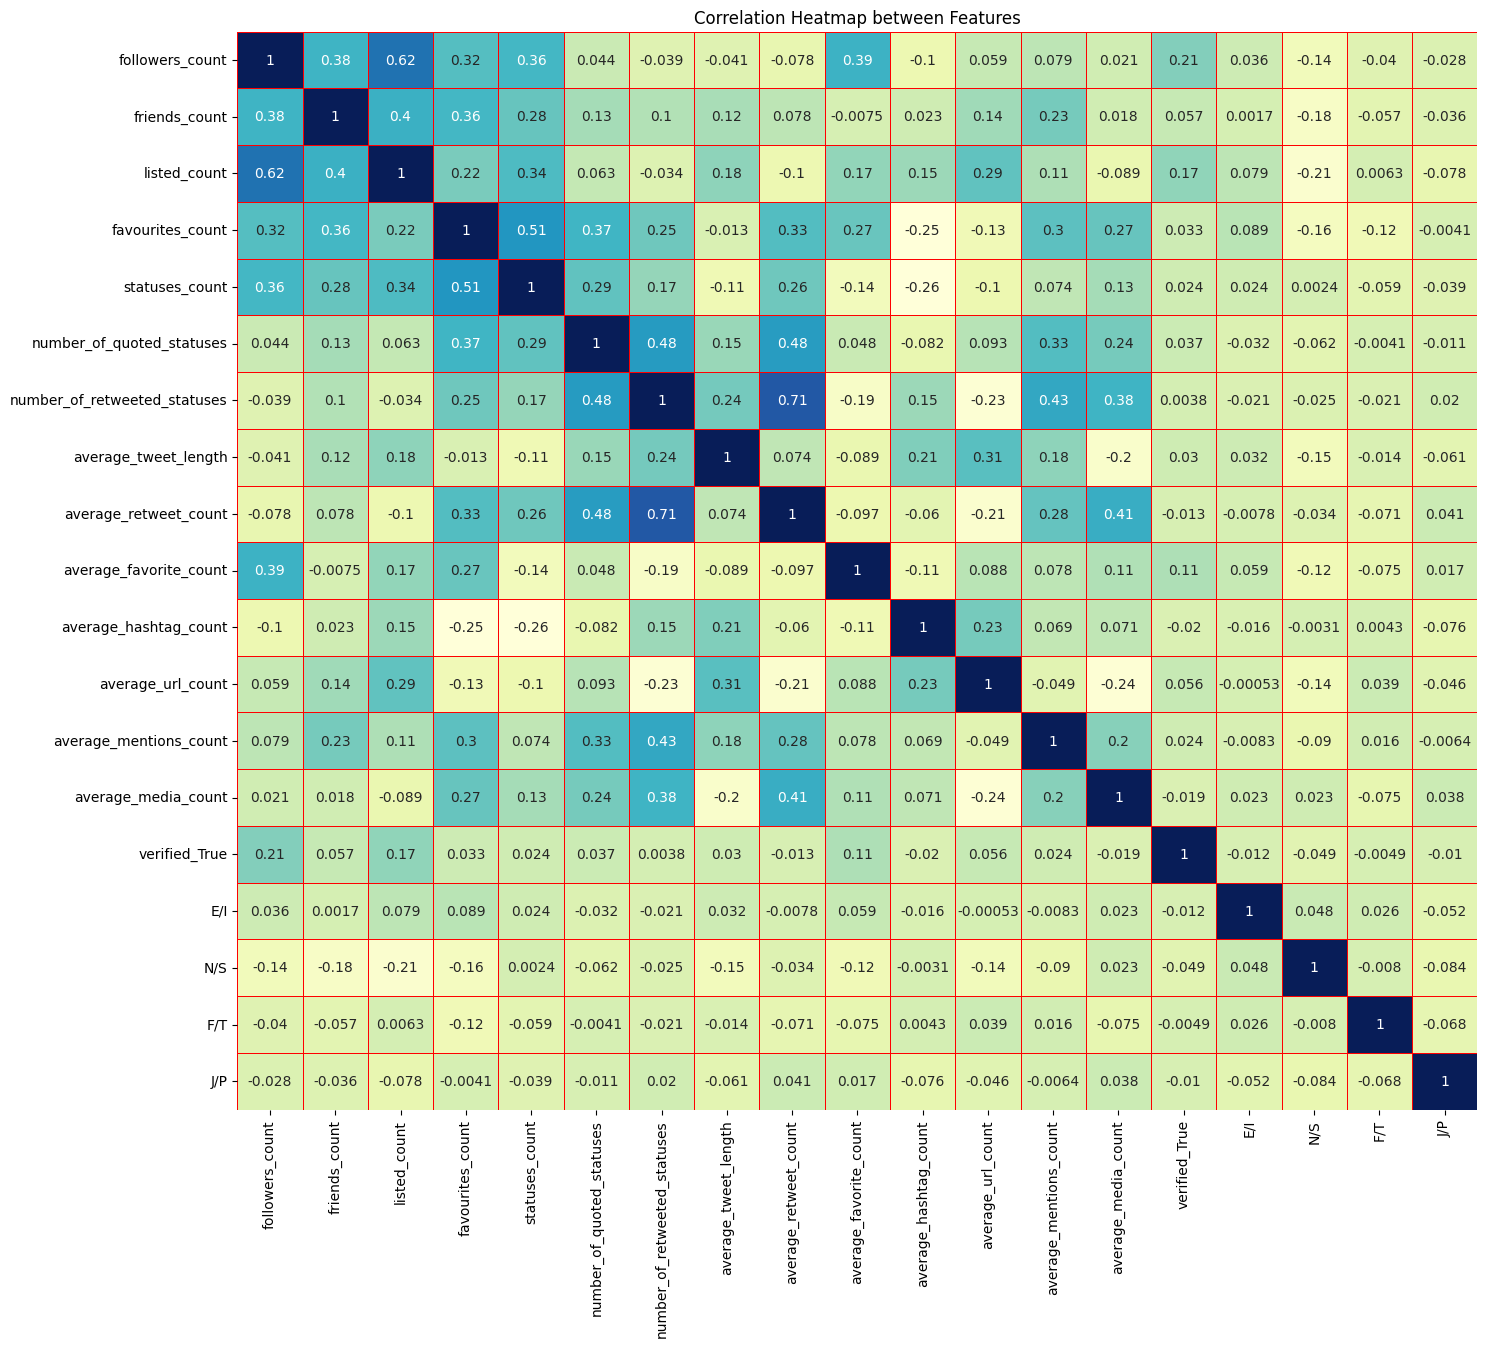

In [ ]:
# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(user_info_preprocessed.join(y).drop(['id', 'screen_name', 'description'],axis=1).corr(), annot=True, cmap='YlGnBu', linecolor='r', linewidths=0.5, cbar=False)
plt.title('Correlation Heatmap between Features')
plt.show()

In [ ]:
# Save the scaler to the file
file_path_scaler = f'/content/drive/MyDrive/comp4211/project/scaler.pkl'
with open(file_path_scaler, 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
# Load the scaler
with open(file_path_scaler, 'rb') as file:
    minmax_scaler = pickle.load(file)